<a name="software-requirements"></a>
## Software Requirements

In [19]:
# Import modules
# Data visualization
import matplotlib.pyplot as plt
import cartopy

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# todo: mount GPU on colab.

<a name="data"></a>
# Data

In [20]:
repo_root = '../'
data_root = '../../../data/climate-emulator-presubmission-tst/data/'

# Uncomment these on MIT svante computer
# repo_root = '../../climate-emulator-tutorial/' 
# data_root = repo_root + 'data/'

path_climatebench_data = data_root + 'raw/climatebench/' # climatebench data

In [21]:
# Test if path works:
# !ls '../../climate-emulator-tutorial/data/raw/climatebench/'
!ls '../../../data/climate-emulator-presubmission-tst/data/raw/climatebench/'

inputs_1pctCO2.nc	inputs_ssp370-lowNTCF.nc  outputs_historical.nc
inputs_abrupt-4xCO2.nc	inputs_ssp370.nc	  outputs_piControl.nc
inputs_hist-GHG.nc	inputs_ssp585.nc	  outputs_ssp126.nc
inputs_hist-aer.nc	outputs_1pctCO2.nc	  outputs_ssp245.nc
inputs_historical.nc	outputs_abrupt-4xCO2.nc   outputs_ssp370-lowNTCF.nc
inputs_ssp126.nc	outputs_hist-GHG.nc	  outputs_ssp370.nc
inputs_ssp245.nc	outputs_hist-aer.nc	  outputs_ssp585.nc


## Data Preprocessing <a name="data-processing"></a>


In [22]:
#@title code: load ClimateBench training data
from emcli2.dataset.climatebench import load_climatebench_data

scenarios_train = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer','historical'] # could leave out hist-aer for training, but didn't really impact nrmse
data_path = path_climatebench_data + '/'

X_train, Y_train = load_climatebench_data(
  simus=scenarios_train, len_historical=0, 
  data_path=data_path)

FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp126
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp370
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp585
FrozenMappingWarningOnValuesAccess({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
FrozenMappingWarningOnValuesAccess({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer
FrozenMappingWarningOnValuesAccess({'time': 165, 'longitude': 144, 'latitude': 96}) historical


In [23]:
#@title code: Normalize training data
# note: climatebench does not normalize outputs, Y_train.
from emcli2.dataset.climatebench import compute_mean_std_X_train
from emcli2.dataset.climatebench import normalize_data_arr

# Compute mean and standard deviations of each input variable
meanstd_inputs = {}
for var in ['CO2', 'CH4', 'SO2', 'BC']:
    meanstd_inputs[var] = compute_mean_std_X_train(data_arr = X_train, var=var)

# Normalize the input data array (not necessary for LPS)
# X_train_norm = normalize_data_arr(data_arr=X_train, meanstd=meanstd_inputs, keys=['CO2', 'CH4', 'SO2', 'BC'])

In [24]:
#@title code: Load test data

scenarios_test = ['ssp245']
len_historical = 165

X_test, Y_test = load_climatebench_data(
  simus=scenarios_test, 
  len_historical=len_historical, 
  data_path=data_path,
  avg_over_ensemble=True)

# (optional) Drop non-relevant variables
# X_test = [X.drop(['SO2','CH4','BC']) for X in X_test]
# Y_test = [Y.drop(['diurnal_temperature_range','pr','pr90']) for Y in Y_test]

# Normalize test data (not necessary for LPS)
# X_test_norm = normalize_data_arr(data_arr=X_test, meanstd=meanstd_inputs)#, keys=['CO2', 'CH4', 'SO2', 'BC'])

FrozenMappingWarningOnValuesAccess({'time': 251, 'latitude': 96, 'longitude': 144}) ssp245


In [25]:
print('Input', X_train[0].data_vars)
print('Output', Y_train[0].data_vars)
print('Training set, number of scenarios: \t\t', len(X_train))
print('Total number of training samples/years: \t', sum([X_scenario['CO2'].shape[0] for X_scenario in X_train]))
print('Training set, shapes of CO2 inputs: \t\t', X_train[0]['CO2'].shape, X_train[-1]['CO2'].shape)
print('Training set, shapes of BC (not used): \t\t', X_train[0]['BC'].shape, X_train[-1]['BC'].shape)
print('Training set, shapes of tas outputs: \t\t', Y_train[0]['tas'].shape, Y_train[-1]['tas'].shape)
print('Test set, number of scenarios:\t\t\t', len(X_test))
print('Test set, shape of CO2 input and tas output:\t', X_test[0]['CO2'].shape, Y_test[0]['tas'].shape)
print('Mean and standard deviations:')
[print('\t' + key + ' train mean, std: \t', meanstd_inputs[key]) for key in meanstd_inputs];

Input Data variables:
    CO2      (time) float64 688B 1.536e+03 1.572e+03 ... 2.798e+03 2.793e+03
    SO2      (time, latitude, longitude) float64 10MB 0.0 0.0 ... 0.0 3.525e-14
    CH4      (time) float64 688B 0.3737 0.3657 0.3576 ... 0.115 0.1143 0.1136
    BC       (time, latitude, longitude) float64 10MB 0.0 0.0 ... 0.0 4.3e-15
Output Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 5MB dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    tas                        (time, latitude, longitude) float32 5MB dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    pr                         (time, latitude, longitude) float64 10MB dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    pr90                       (time, latitude, longitude) float64 10MB dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
Training set, number of scenarios: 		 6
Total number of training samples/years: 	 753
Training set, shapes of CO2 inputs: 		 (86,) (165,)
Traini

## Data Visualization:


In [116]:
data_var_labels = {
    'tas': {
        'abbrev': 'tas',
        'ylabel': 'Annual Global Surface \n Temperate Anomaly in °C',
        'title': 'Surface Temperature, "tas"',
        'unit': '°C',
    },
    'pr': {
        'abbrev': 'pr',
        'ylabel': 'Annual Mean Precipitation Anomaly in mm/day',
        'title': 'Precipitation, "pr"',
        'unit': 'mm/day',
    },
    'diurnal_temperature_range': {
        'abbrev': 'dtr',
        'ylabel': 'Annual Diurnal Temperature Range Anomaly in °C',
        'title': 'Diurnal Temperature Range, "dtr"',
        'unit': '°C',
    },
    'pr90': {
        'abbrev': 'pr90',
        'ylabel': 'Annual Mean Extreme Precipitation Anomaly in mm/day',
        'title': 'Extreme Precipitation, "pr90"',
        'unit': 'mm/day',
    }
}

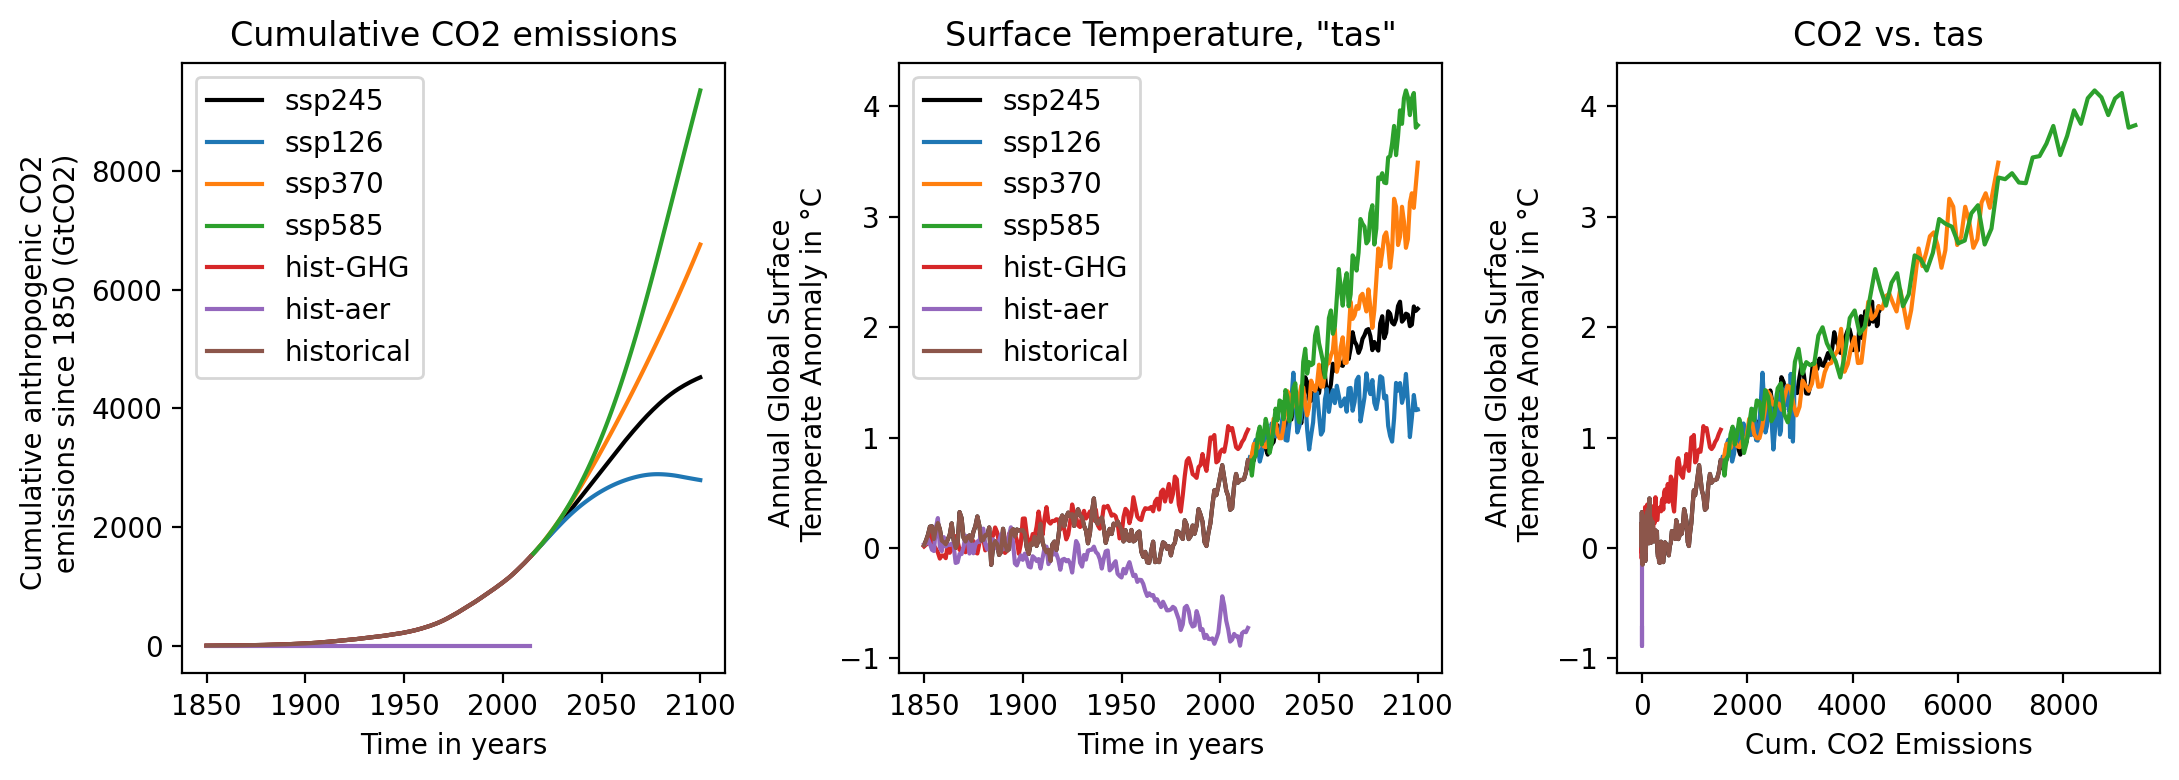

In [59]:
%reload_ext autoreload
%aimport emcli2

import emcli2.utils.plotting as plotting
data_var = 'tas'
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          data_var=data_var,
          data_var_labels=data_var_labels);

<a name="methodology"></a>
# Methodology

#### Global linear time-instant mapping: global GHG -> global tas

In [60]:
#@title: fit linear model for global GHGs -> global tas

import emcli2.models.pattern_scaling.model as ps
import emcli2.dataset.interim_to_processed as i2p

# Convert training data from interim to processed
data_var = 'tas' # 'tas', 'pr'
dir_global_global = data_root + 'interim/global_global/'
input_train, target_train = i2p.interim_to_global_global(
                             X_global_local=X_train,
                             Y_global_local=Y_train,
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'train/')

print(target_train.shape)
# Fit Linear regression model from global ghg at t -> global data_var as t
model_lr = ps.fit_linear_regression_global_global(data_dir=dir_global_global+'train/', plot=False)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_co2_to_global_{data_var}.pkl'
ps.save(model_lr, dir=dir_pattern_scaling, filename=model_name)

# Convert test data from interim to processed
input_test, target_test = i2p.interim_to_global_global(X_global_local=X_test, # [X_train[2]],# 
                             Y_global_local=Y_test, # [Y_train[2]],#
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'test/')

# Load model
# model_lr = ps.load(dir=dir_pattern_scaling, filename=model_name)

# Apply linear regression model on test data
preds_lr = ps.predict_linear_regression_global_global(model_lr, 
            data_dir=dir_global_global+'test/',
            plot=False)

Saving processed data at:  ../../../data/climate-emulator-presubmission-tst/data/interim/global_global/train/
(753, 1, 1, 1)
Saving processed data at:  ../../../data/climate-emulator-presubmission-tst/data/interim/global_global/test/


/home/bjoern/miniconda3/envs/emcli-presubmission-tst/lib/python3.12/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/bjoern/miniconda3/envs/emcli-presubmission-tst/lib/python3.12/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


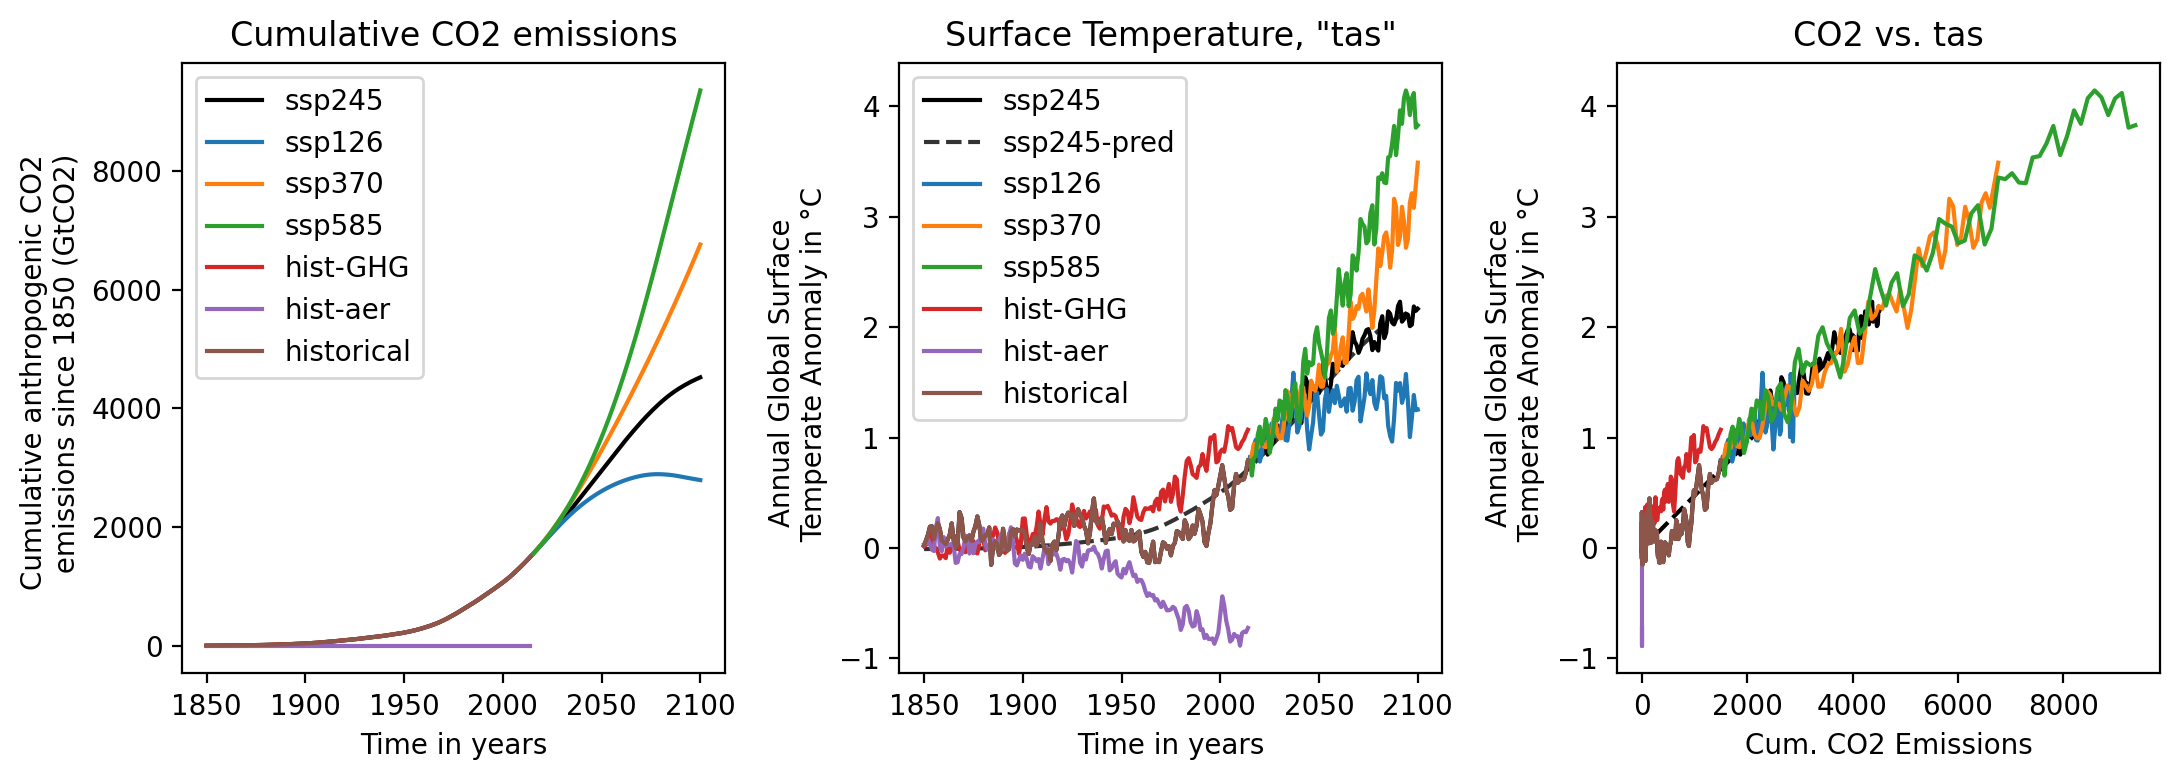

In [61]:
# Plot linear regression predictions

import emcli2.utils.plotting as plotting
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          preds=preds_lr,
          data_var=data_var,
          data_var_labels=data_var_labels);

#### Train and evaluate linear pattern scaling (LPS): global tas -> local climate variable

To calculate metrics for each data variable, change "data_var"

In [127]:
#@title: fit linear pattern scaling model for global tas -> local tas

import emcli2
import importlib
importlib.reload(emcli2)
#from emcli.models.pattern_scaling.model import PatternScaling
#from emcli.models.pattern_scaling.model import save
import emcli2.models.pattern_scaling.model as ps

################
# Change data_var here to calculate metrics for each variable
# 
data_var = 'tas' # 'tas', 'pr', 'pr90', 'diurnal_temperature_range'
# 
###############
# Retrieve global temperatures for training
var_global = target_train.flatten() # (n_time,)
# Retrieve annual local temperature field for training
var_local = np.concatenate([dataset[data_var].data for dataset in Y_train],axis=0) # (n_time, n_lat, n_lon)

# Initialize and fit pattern scaling model
pattern_scaling = ps.PatternScaling(deg=1)
pattern_scaling.train(var_global, var_local)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_tas_to_local_{data_var}.pkl'
ps.save(pattern_scaling, dir=dir_pattern_scaling,filename=model_name)

# Retrieve test data. Use global tas predictions from previous model as input
var_global_test = preds_lr.flatten() # (n_time,)
# var_global_test = target_test.flatten() # (n_time,) # uncomment to use ground-truth global tas as input

# Load model
# pattern_scaling = ps.load(dir=dir_pattern_scaling)

# Apply pattern scaling model on test data
preds_pattern_scaling = pattern_scaling.predict(var_global_test) # (n_time, n_lat, n_lon)

/home/bjoern/miniconda3/envs/emcli-presubmission-tst/lib/python3.12/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


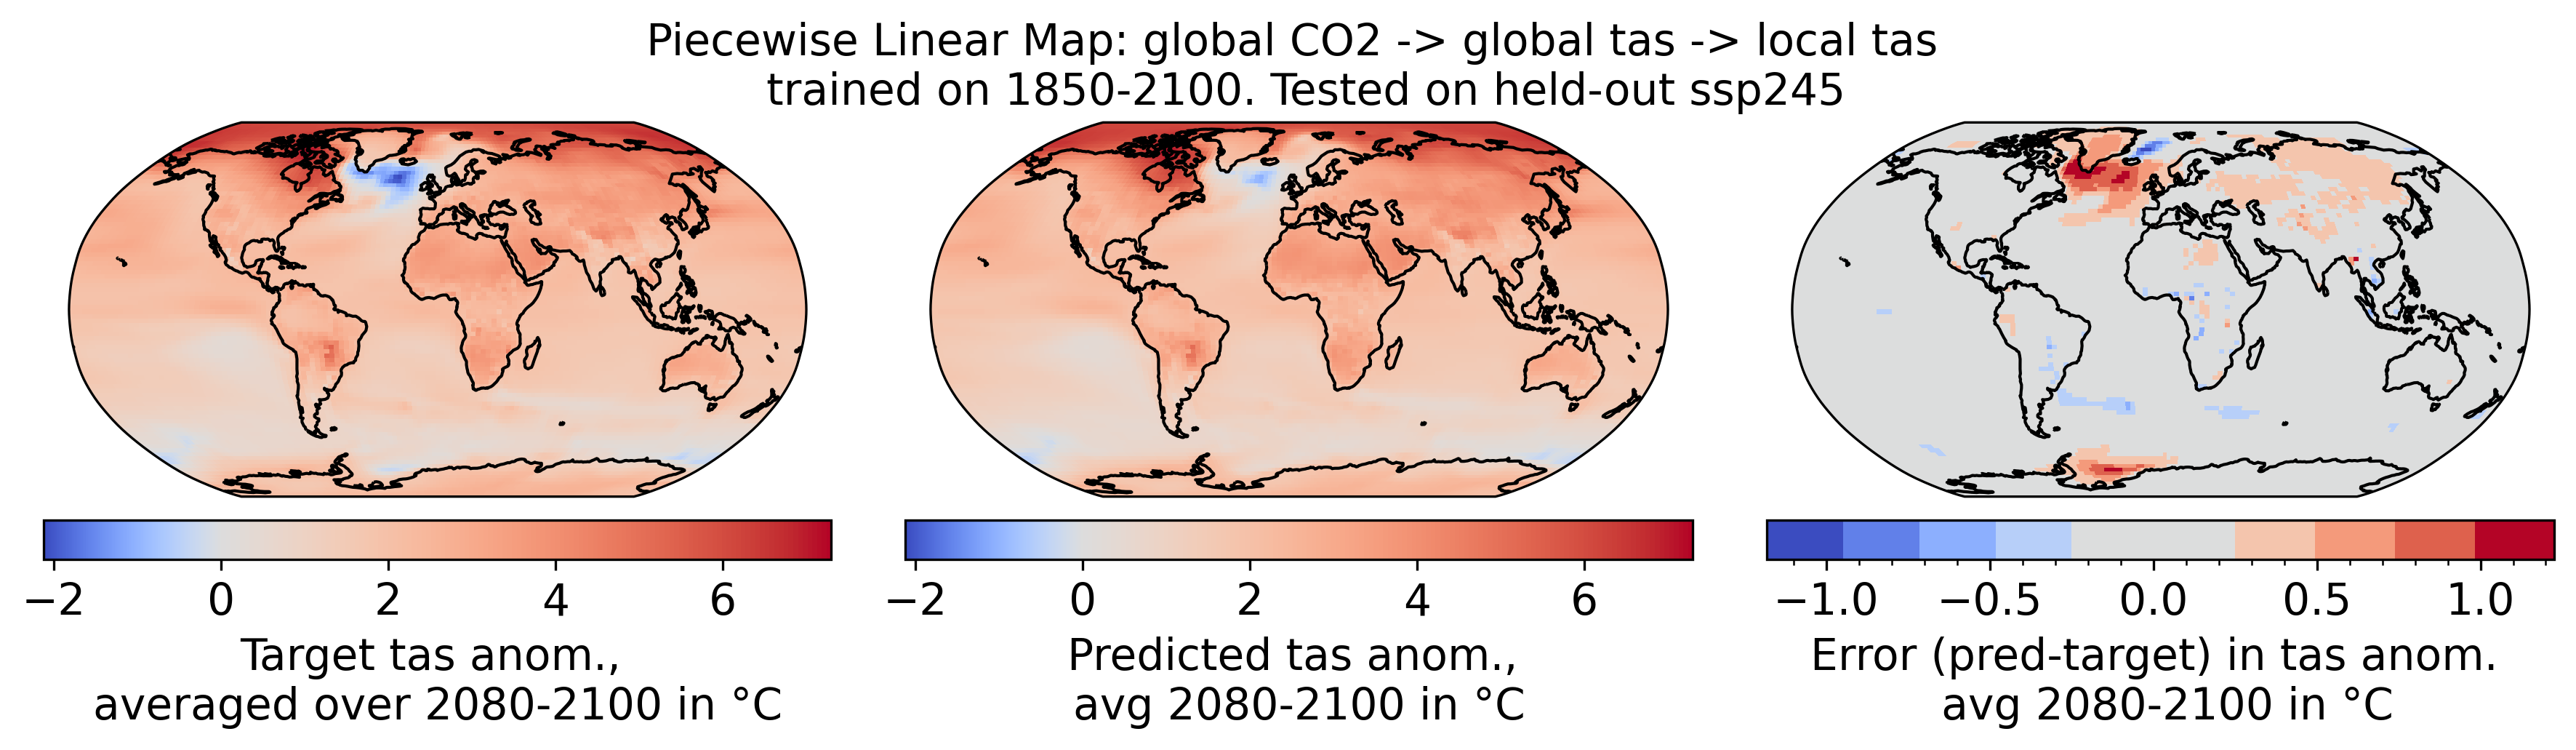

In [129]:
# Plot the Linear Pattern Scaling error map for the selected climate variable
from emcli2.utils.plotting import plot_tas_annual_local_err_map

preds_pattern_scaling_xr = xr.DataArray(data=preds_pattern_scaling, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_ds = [xr.merge([preds_pattern_scaling_xr])]
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], 
    preds_pattern_scaling_ds[0][data_var], 
    data_var=data_var_labels[data_var]['abbrev'], 
    unit=data_var_labels[data_var]['unit'],
    filepath_to_save=f'{repo_root}/docs/figures/climatebench/{data_var_labels[data_var]["abbrev"]}/pattern_scaling/ssp245_2080_2100/preds_map.png')
axs[1].set_title(f'Piecewise Linear Map: global CO2 -> global tas -> local {data_var} \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

In [96]:
# Test if nrmse calculation works:
from emcli2.utils.metrics import calculate_nrmse

Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_ds[0][data_var], normalize=True)
print(Y_nrmse.compute())

0.0786087528055768


In [97]:
# Compute spatial, global, and total NRMSE for the selected data_var for the ClimateBench scoreboard.

import pandas as pd
from xskillscore import rmse

def compute_metrics(variables, model_labels,models):
    """
    Evaluation script. Src:
    https://github.com/duncanwp/ClimateBench/blob/main/analysis_notebooks/paper_figures.ipynb
    Commit: e905292 (9/9/2022)
    """
    Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')
    Y = Y.rename({'lon':'longitude', 'lat': 'latitude'})
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400

    weights = np.cos(np.deg2rad(Y['tas'].latitude)).expand_dims(longitude=144).assign_coords(lon=Y.longitude)

    def global_mean(ds):
        weights = np.cos(np.deg2rad(ds.latitude))
        return ds.weighted(weights).mean(['latitude', 'longitude'])

    # Spatial NRMSE
    NRMSE = pd.DataFrame({
        label: {variable: rmse(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                                model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
        for label, model in zip(model_labels, models)
    })
    NRMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")
    print(f'spatial NRMSE, {NRMSE.keys()[0]} {NRMSE.index[0]}: {NRMSE[NRMSE.keys()[0]][NRMSE.index[0]]}')

    # Global NRMSE
    R2E = pd.DataFrame({
        label: {variable: rmse( global_mean(Y.mean('member')[variable].sel(time=slice(2080, None))), 
                                    global_mean(model[variable].sel(time=slice(2080, None)))).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    #                                 global_mean(model[variable].sel(time=slice(2080, None)))).data for variable in variables} 
                            for label, model in zip(model_labels[:], models[:])
    })
    R2E.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")
    print(f'global NRMSE, {R2E.keys()[0]} {R2E.index[0]}: {R2E[R2E.keys()[0]][R2E.index[0]]}')

    # Total NRMSE
    total_nrmse = (NRMSE+5*R2E)
    total_nrmse.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")
    print(f'total NRMSE, {total_nrmse.keys()[0]} {total_nrmse.index[0]}: {total_nrmse[total_nrmse.keys()[0]][total_nrmse.index[0]]}')

    combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total'])[model_labels[:]].T.swaplevel(axis=1)[variables]
    combined_df.style.highlight_min(subset=slice(None, "Random Forest"), axis = 0, props='font-weight: bold').format("{:.3f}")

    return combined_df

variables = [data_var]
model_labels = ['Linear Pattern Scaling']
models = [preds_pattern_scaling_ds[0]]

print('The following scores should match the scores for LPS in the ClimateBench scoreboard in the JAMES24 paper submission:')
compute_metrics(variables, model_labels,models)

The following scores should match the scores for LPS in the ClimateBench scoreboard in the JAMES24 paper submission:
spatial NRMSE, Linear Pattern Scaling tas: 0.0786087528055768
global NRMSE, Linear Pattern Scaling tas: 0.040997479742458154
total NRMSE, Linear Pattern Scaling tas: 0.28359615151786755


tas                    
                         Spatial    Global     Total
Linear Pattern Scaling  0.078609  0.040997  0.283596

### (optional) print normalization coefficient and separately compute RMSE

In [98]:
from pprint import pprint
from emcli2.dataset.interim_to_processed import calculate_global_weighted_average

norm_coefficient = dict()
for data_variable in Y_test[0].data_vars:
    Y_true_mean = Y_test[0][data_variable].sel(time=slice("2080",None)).mean('time') 
    Y_true_abs = np.abs(calculate_global_weighted_average(Y_true_mean)).data
    norm_coefficient[data_variable] = Y_true_abs.compute()

print('Normalization coefficients:')
pprint(norm_coefficient)

Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')
Y = Y.rename({'lon':'longitude', 'lat': 'latitude'})
# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

weights = np.cos(np.deg2rad(Y['tas'].latitude)).expand_dims(longitude=144).assign_coords(lon=Y.longitude)

RMSE = pd.DataFrame({
    label: {variable: rmse(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data for variable in variables} 
    for label, model in zip(model_labels, models)
})
RMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")
print('Spatial RMSE:')
print(RMSE)

Y.close(); del Y

Normalization coefficients:
{'diurnal_temperature_range': 0.011198246732586495,
 'pr': 0.06519245518062773,
 'pr90': 0.15468088979008324,
 'tas': 2.0705421003592264}
Spatial RMSE:
    Linear Pattern Scaling
tas     0.1627627321406782


### (optional) visualize all data variables as global-averages

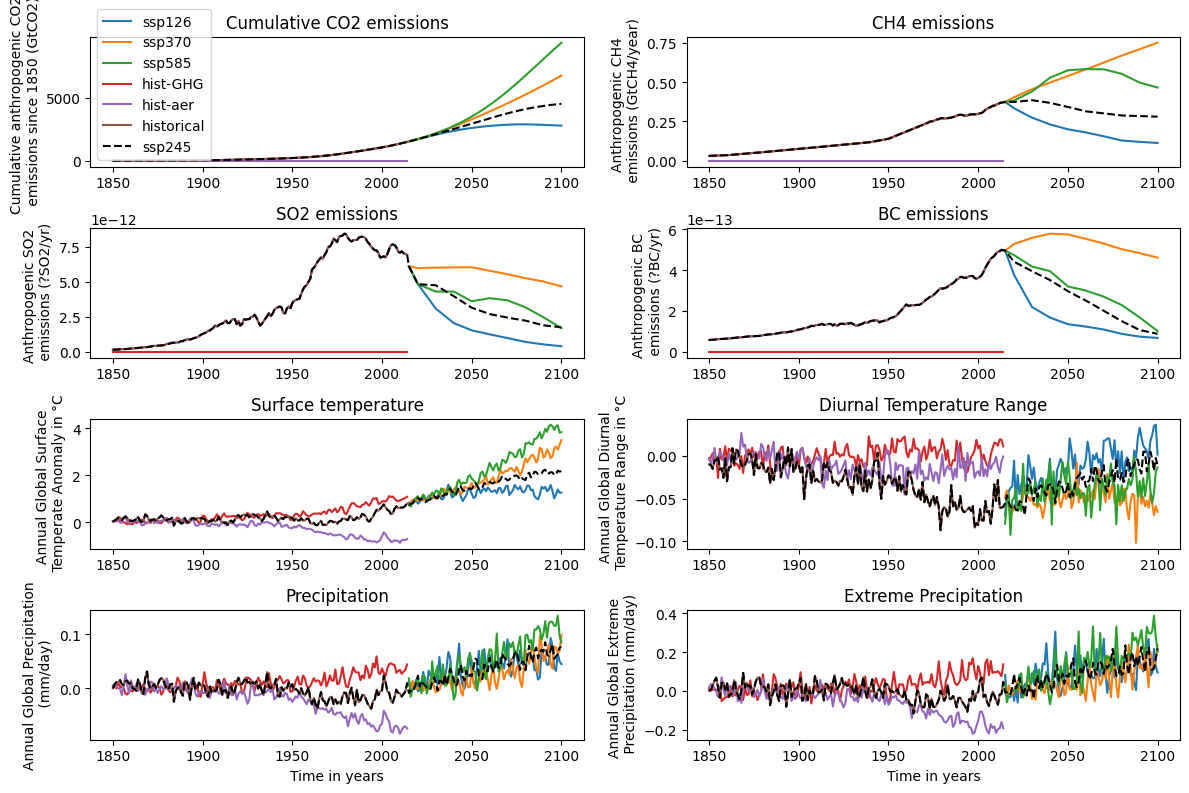

In [99]:
import emcli2.utils.plotting as plotting

axs = plotting.plot_all_vars_global_avg(X_train=X_train, 
            X_test=X_test, 
            Y_train=Y_train, 
            Y_test=Y_test,
            scenarios_train=scenarios_train,
            scenarios_test=scenarios_test)